In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)
import re
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [19]:
train_i = pd.read_csv('train_identity.csv')
train_t = pd.read_csv('train_t.csv')

In [20]:
y_train = train_t.isFraud
train_t = train_t.drop('isFraud', axis=1)

In [21]:
train_t['Transaction_day_of_week'] = np.floor((train_t['TransactionDT'] / (3600 * 24) - 1) % 7)

In [23]:
train_t.shape

(590540, 415)

In [30]:
train_t['Trans_min_mean'] = train_t['TransactionAmt'] - train_t['TransactionAmt'].mean()
train_t['Trans_min_std'] = train_t['Trans_min_mean'] / train_t['TransactionAmt'].std()
train_t['Trans_min_mean'] = train_t['TransactionAmt'] - train_t['TransactionAmt'].mean()
train_t['Trans_min_std'] = train_t['Trans_min_mean'] / train_t['TransactionAmt'].std()

In [32]:
import datetime
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train_t["Date"] = train_t['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train_t['_Weekdays'] = train_t['Date'].dt.dayofweek

In [35]:
def corret_card_id(x): 
    x=x.replace('.0','')
    x=x.replace('-999','nan')
    return x

def definie_indexes(df):

    
    # create card ID 
    cards_cols= ['card1', 'card2', 'card3', 'card5']
    for card in cards_cols: 
        if '1' in card: 
            df['Card_ID']= df[card].map(str)
        else : 
            df['Card_ID']+= ' '+df[card].map(str)
    
    # sort train data by Card_ID and then by transaction date 
    df= df.sort_values(['Card_ID', 'Date'], ascending=[True, True])
    
    # small correction of the Card_ID
    df['Card_ID']=df['Card_ID'].apply(corret_card_id)
    
    df['mean_last'] = df['TransactionAmt'] - df.groupby('Card_ID')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).mean())
    df['min_last'] = df.groupby('Card_ID')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).min())
    df['max_last'] = df.groupby('Card_ID')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).max())
    df['std_last'] = df['mean_last'] / df.groupby('Card_ID')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).std())
    # df['count_last'] = df.groupby('Card_ID')['TransactionAmt'].transform(lambda x: x.rolling(30, 1).count())
    df['mean_last'].fillna(0, inplace=True, )
    df['std_last'].fillna(0, inplace=True)
    
    return df

In [36]:
train_t = definie_indexes(train_t)

In [37]:
train_t['TransactionAmt_to_mean_card_id'] = train_t['TransactionAmt'] - train_t.groupby(['Card_ID'])['TransactionAmt'].transform('mean')
train_t['TransactionAmt_to_std_card_id'] = train_t['TransactionAmt_to_mean_card_id'] / train_t.groupby(['Card_ID'])['TransactionAmt'].transform('std')
train_t['TransactionAmt_to_mean_card_id'] = train_t['TransactionAmt'] - train_t.groupby(['Card_ID'])['TransactionAmt'].transform('mean')
train_t['TransactionAmt_to_std_card_id'] = train_t['TransactionAmt_to_mean_card_id'] / train_t.groupby(['Card_ID'])['TransactionAmt'].transform('std')

In [46]:
train_t.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card_type,card5,card_category,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,...,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,domain_p,end_domain_p,foreign_p,Transaction_time_days,v_prod,D1_binned,D10_binned,card2_binned,card5_binned,addr1_binned,D1_binnedq,D10_binnedq,card2_binnedq,card3_binnedq,card5_binnedq,addr1_binnedq,card3_binnedb,hours,time_of_day,rush_hour,party_hours,random,amount_description,Transaction_day_of_week,Trans_min_mean,Trans_min_std,Date,_Weekdays,Card_ID,mean_last,min_last,max_last,std_last,TransactionAmt_to_mean_card_id,TransactionAmt_to_std_card_id,sleeping_time,avg_trans_day
243924,3230924,5787419,23.443,C,1000,555.0,185.0,mastercard,224.0,debit,291.0,291.0,-999.0,gmail.com,gmail.com,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,-999.0,-999.0,5.0,5.0,5.0,4.958333,0.958333,0.0,-999.0,5.0,5.0,0.0,5.0,missing,missing,missing,M2,missing,missing,missing,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,gmail,.com,no,66.984016,4.875,6.243,6.895,6.165,8.471,5.629,4.191,5.346,7.107,1.789,7.131,4.504,1.737,4,4AM,False,False,-1.036401,more than minimal,2.0,-111.584176,-0.466562,2018-02-05 23:36:59,0,1000 555 185 224,0.0000,23.443,23.443,0.000000,0.00000,NaN,False,70223.0
182988,3169988,4050851,29.000,W,10000,111.0,150.0,mastercard,117.0,debit,184.0,87.0,-999.0,gmail.com,missing,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,83.0,83.0,70.0,70.0,70.0,-999.0,-999.000000,-999.000000,83.0,-999.0,-999.0,-999.0,-999.0,83.0,missing,missing,missing,M0,F,F,missing,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,gmail,.com,no,46.884850,9.380,10.709,10.344,9.687,7.799,9.319,10.700,10.315,9.790,18.867,101.314,9.394,19.045,16,4PM,True,False,-1.267116,more than minimal,3.0,-106.027176,-0.443327,2018-01-16 21:14:11,1,10000 111 150 117,0.0000,29.000,29.000,0.000000,0.00000,NaN,False,85433.0
314550,3301550,7840676,42.777,C,10003,363.0,150.0,visa,199.0,debit,291.0,291.0,-999.0,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,0.0,-999.000000,-999.000000,0.0,-999.0,0.0,0.0,0.0,0.0,missing,missing,missing,M2,missing,missing,missing,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,gmail,.com,no,90.748565,4.875,6.243,6.895,7.648,20.812,5.629,4.191,5.346,9.423,18.867,16.862,4.504,19.045,3,3AM,False,False,-0.840887,more than minimal,5.0,-92.250176,-0.385722,2018-03-01 17:57:56,3,10003 363 150 199,0.0000,42.777,42.777,0.000000,0.00000,NaN,True,85356.0
341484,3328484,8421815,39.394,C,10003,555.0,128.0,visa,226.0,debit,291.0,291.0,-999.0,gmail.com,gmail.com,1.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,1.0,7.0,7.0,7.0,7.0,7.0,7.0,7.458333,0.458333,0.0,-999.0,7.0,7.0,0.0,0.0,missing,missing,missing,M2,missing,missing,missing,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,gmail,.com,no,97.474711,4.875,6.243,6.895,6.165,8.471,5.629,15.523,5.346,7.107,18.867,8.888,4.504,2.837,11,11AM,False,False,0.238355,more than minimal,5.0,-95.633176,-0.399867,2018-03-08 11:23:35,3,10003 555 128 226,0.0000,39.394,39.394,0.000000,17.31025,1.419900,False,85356.0
350343,3337343,8634882,10.755,C,10003,555.0,128.0,visa,226.0,debit,291.0,291.0,-999.0,missing,missing,1.0,3.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,2.0,2.0,3.0,1.0,9.0,9.0,2.0,-999.0,-999.0,-999.0,9.916666,0.916666,0.0,-999.0,-999.0,9.0,0.0,-999.0,missing,missing,missing,missing,missing,missing,missing,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,missing,missing,yes,99.940764,4.875,6.243,6.895,6.165,8.471,5.629,15.523,5.346,7.107,18.867,8.888,4.504,2.837,21,9PM,False,True,-0.086963,minimal

In [42]:
train_t.loc[(train_t['hours']!=1)|(train_t['hours']!=2)|
            (train_t['hours']!=3)|(train_t['hours']!=5)|(train_t['hours']!=6),'sleeping_time']='False'
train_t.loc[(train_t['hours']==1)|(train_t['hours']==2)|
            (train_t['hours']==3)|(train_t['hours']==5)|(train_t['hours']==6),'sleeping_time']='True'

In [44]:
av_per_week = train_t.groupby('Transaction_day_of_week')['TransactionAmt'].count()
av_per_week
train_t.loc[train_t['Transaction_day_of_week']==0, 'avg_trans_day']=98502
train_t.loc[train_t['Transaction_day_of_week']==1, 'avg_trans_day']=79834
train_t.loc[train_t['Transaction_day_of_week']==2, 'avg_trans_day']=70223
train_t.loc[train_t['Transaction_day_of_week']==3, 'avg_trans_day']=85433
train_t.loc[train_t['Transaction_day_of_week']==4, 'avg_trans_day']=84815
train_t.loc[train_t['Transaction_day_of_week']==5, 'avg_trans_day']=85356
train_t.loc[train_t['Transaction_day_of_week']==6, 'avg_trans_day']=86377

In [58]:
def melt_D(df):
    melted_dict = {}
    for col in df:
        d_cols_melt = [col for col in df.columns if (('D' in col) and ('binned' not in col))]
        if not re.match('D',col):
            by = df.groupby(col)[d_cols_melt].agg('mean').reset_index()
            melter = pd.melt(by, id_vars=col, value_vars=[col for col in df.columns if 'D' in col])
            meaner = melter.groupby(col)['value'].agg('mean')
            melted_dict[col]=meaner  
    return melted_dict    

In [66]:
hil = meltd.corr()['v_prod']

In [64]:
melt_w_d = [col for col in train_t.columns if (('D' in col) and ('binned' not in col))]
melt_w_d2 = ['card1', 'card2','card3','card_type', 'card5', 'card_category', 'addr1', 'addr2', 'P_emaildomain','v_prod']
melt_d = melt_w_d+melt_w_d2
meltd = train_t[melt_d]

In [65]:
meltd = meltd.drop(['Date', 'TransactionID', 'TransactionDT', 'Card_ID'],axis=1)
# meltd = melt_D(meltd)

## Train Identity

In [149]:
train_i['id_02'] = train_i['id_02'].fillna(round(train_i['id_02'].mode(),0))
train_i['id_05'] = train_i['id_05'].fillna(train_i['id_05'].mode()[0])
train_i['id_06'] = train_i['id_06'].fillna(train_i['id_06'].mode()[0])
train_i['id_07'] = train_i['id_07'].fillna(round(train_i['id_07'].astype(np.float32).mean(),0))
train_i['id_08'] = train_i['id_08'].fillna(round(train_i['id_08'].astype(np.float32).mean(),0))

train_i['id_11'] = train_i['id_11'].fillna(train_i['id_11'].mode()[0])
train_i['id_13'] = train_i['id_13'].fillna(round(train_i['id_13'].astype(np.float32).mean(),0))
train_i['id_15'] = train_i['id_15'].fillna('missing')
train_i['id_16'] = train_i['id_16'].fillna('missing')
train_i['id_17'] = train_i['id_17'].fillna(-999)
train_i['id_18'] = train_i['id_18'].fillna(round(train_i['id_18'].astype(np.float32).mean(),0))
train_i['id_19'] = train_i['id_19'].fillna(round(train_i['id_19'].astype(np.float32).mean(),0))
train_i['id_20'] = train_i['id_20'].fillna(round(train_i['id_20'].astype(np.float32).mean(),0))
train_i['id_21'] = train_i['id_21'].fillna(train_i['id_21'].mode()[0])
train_i['id_22'] = train_i['id_22'].fillna(train_i['id_22'].mode()[0])
train_i['id_23'] = train_i['id_23'].fillna('missing')
train_i['id_24'] = train_i['id_24'].fillna(-999)
train_i['id_25'] = train_i['id_25'].fillna(-999)
train_i['id_26'] = train_i['id_26'].fillna(-999)
train_i['id_27'] = train_i['id_27'].fillna('missing')
train_i['id_28'] = train_i['id_28'].fillna('missing')
train_i['id_29'] = train_i['id_29'].fillna('missing')
train_i['id_31'] = train_i['id_31'].fillna('missing')
train_i['id_35'] = train_i['id_35'].fillna('missing')
train_i['id_36'] = train_i['id_36'].fillna('missing')
train_i['id_37'] = train_i['id_37'].fillna('missing')
train_i['id_38'] = train_i['id_38'].fillna('missing')
train_i['DeviceType'] = train_i['DeviceType'].fillna('missing')
train_i['id_03'] = train_i['id_03'].fillna(-999)
train_i['id_04'] = train_i['id_04'].fillna(-999)
train_i['id_09'] = train_i['id_09'].fillna(-999)
train_i['id_10'] = train_i['id_10'].fillna(-999)
train_i['id_14'] = train_i['id_14'].fillna(-999)
train_i['id_30'] = train_i['id_30'].fillna('missing')
train_i['id_32'] = train_i['id_32'].fillna(-999)
train_i['id_33'] = train_i['id_33'].fillna('missing')
train_i['id_34'] = train_i['id_34'].fillna('missing')
train_i['DeviceInfo'] = train_i['DeviceInfo'].fillna('-1')

In [150]:
train_i.isna().sum()

TransactionID    0
id_01            0
id_02            0
id_03            0
id_04            0
id_05            0
id_06            0
id_07            0
id_08            0
id_09            0
id_10            0
id_11            0
id_12            0
id_13            0
id_14            0
id_15            0
id_16            0
id_17            0
id_18            0
id_19            0
id_20            0
id_21            0
id_22            0
id_23            0
id_24            0
id_25            0
id_26            0
id_27            0
id_28            0
id_29            0
id_30            0
id_31            0
id_32            0
id_33            0
id_34            0
id_35            0
id_36            0
id_37            0
id_38            0
DeviceType       0
DeviceInfo       0
dtype: int64

### Concat both data sets

In [151]:
train_x = train_t.merge(train_i, how='left', on='TransactionID')

In [153]:
train_x['id_07'] = train_x['id_07'].fillna(-999)
train_x['id_08'] = train_x['id_08'].fillna(-999)

train_x['id_11'] = train_x['id_11'].fillna(-999)
train_x['id_13'] = train_x['id_13'].fillna(-999)
train_x['id_15'] = train_x['id_15'].fillna('missing')
train_x['id_16'] = train_x['id_16'].fillna('missing')
train_x['id_17'] = train_x['id_17'].fillna(-999)
train_x['id_18'] = train_x['id_18'].fillna(-999)
train_x['id_19'] = train_x['id_19'].fillna(-999)
train_x['id_20'] = train_x['id_20'].fillna(-999)
train_x['id_21'] = train_x['id_21'].fillna(-999)
train_x['id_22'] = train_x['id_22'].fillna(-999)
train_x['id_23'] = train_x['id_23'].fillna('missing')
train_x['id_24'] = train_x['id_24'].fillna(-999)
train_x['id_25'] = train_x['id_25'].fillna(-999)
train_x['id_26'] = train_x['id_26'].fillna(-999)
train_x['id_27'] = train_x['id_27'].fillna('missing')
train_x['id_28'] = train_x['id_28'].fillna('missing')
train_x['id_29'] = train_x['id_29'].fillna('missing')
train_x['id_31'] = train_x['id_31'].fillna('missing')
train_x['id_35'] = train_x['id_35'].fillna('missing')
train_x['id_36'] = train_x['id_36'].fillna('missing')
train_x['id_37'] = train_x['id_37'].fillna('missing')
train_x['id_38'] = train_x['id_38'].fillna('missing')
train_x['DeviceType'] = train_x['DeviceType'].fillna('missing')
train_x['id_03'] = train_x['id_03'].fillna(-999)
train_x['id_04'] = train_x['id_04'].fillna(-999)
train_x['id_09'] = train_x['id_09'].fillna(-999)
train_x['id_10'] = train_x['id_10'].fillna(-999)
train_x['id_14'] = train_x['id_14'].fillna(-999)
train_x['id_30'] = train_x['id_30'].fillna('missing')
train_x['id_32'] = train_x['id_32'].fillna(-999)
train_x['id_33'] = train_x['id_33'].fillna('missing')
train_x['id_34'] = train_x['id_34'].fillna('missing')
train_x['DeviceInfo'] = train_x['DeviceInfo'].fillna('-1')

In [161]:
train_x['id_01'] = train_x['id_01'].fillna(-999)
train_x['id_02'] = train_x['id_02'].fillna(-999)
train_x['id_05'] = train_x['id_05'].fillna(-999)
train_x['id_06'] = train_x['id_06'].fillna(-999)

train_x['TransactionAmt_to_std_card_id'] = train_x['TransactionAmt_to_std_card_id'].fillna(-999)
train_x['DeviceInfo'] = train_x['DeviceInfo'].fillna('-1')

### Time Series Split

In [162]:
train_t.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card_type,card5,card_category,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,...,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,domain_p,end_domain_p,foreign_p,Transaction_time_days,v_prod,D1_binned,D10_binned,card2_binned,card5_binned,addr1_binned,D1_binnedq,D10_binnedq,card2_binnedq,card3_binnedq,card5_binnedq,addr1_binnedq,card3_binnedb,hours,time_of_day,rush_hour,party_hours,random,amount_description,Transaction_day_of_week,Trans_min_mean,Trans_min_std,Date,_Weekdays,Card_ID,mean_last,min_last,max_last,std_last,TransactionAmt_to_mean_card_id,TransactionAmt_to_std_card_id,sleeping_time,avg_trans_day
243924,3230924,5787419,23.443,C,1000,555.0,185.0,mastercard,224.0,debit,291.0,291.0,-999.0,gmail.com,gmail.com,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,-999.0,-999.0,5.0,5.0,5.0,4.958333,0.958333,0.0,-999.0,5.0,5.0,0.0,5.0,missing,missing,missing,M2,missing,missing,missing,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,gmail,.com,no,66.984016,4.875,6.243,6.895,6.165,8.471,5.629,4.191,5.346,7.107,1.789,7.131,4.504,1.737,4,4AM,False,False,-1.036401,more than minimal,2.0,-111.584176,-0.466562,2018-02-05 23:36:59,0,1000 555 185 224,0.0000,23.443,23.443,0.000000,0.00000,NaN,False,70223.0
182988,3169988,4050851,29.000,W,10000,111.0,150.0,mastercard,117.0,debit,184.0,87.0,-999.0,gmail.com,missing,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,83.0,83.0,70.0,70.0,70.0,-999.0,-999.000000,-999.000000,83.0,-999.0,-999.0,-999.0,-999.0,83.0,missing,missing,missing,M0,F,F,missing,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,gmail,.com,no,46.884850,9.380,10.709,10.344,9.687,7.799,9.319,10.700,10.315,9.790,18.867,101.314,9.394,19.045,16,4PM,True,False,-1.267116,more than minimal,3.0,-106.027176,-0.443327,2018-01-16 21:14:11,1,10000 111 150 117,0.0000,29.000,29.000,0.000000,0.00000,NaN,False,85433.0
314550,3301550,7840676,42.777,C,10003,363.0,150.0,visa,199.0,debit,291.0,291.0,-999.0,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,0.0,-999.000000,-999.000000,0.0,-999.0,0.0,0.0,0.0,0.0,missing,missing,missing,M2,missing,missing,missing,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,gmail,.com,no,90.748565,4.875,6.243,6.895,7.648,20.812,5.629,4.191,5.346,9.423,18.867,16.862,4.504,19.045,3,3AM,False,False,-0.840887,more than minimal,5.0,-92.250176,-0.385722,2018-03-01 17:57:56,3,10003 363 150 199,0.0000,42.777,42.777,0.000000,0.00000,NaN,True,85356.0
341484,3328484,8421815,39.394,C,10003,555.0,128.0,visa,226.0,debit,291.0,291.0,-999.0,gmail.com,gmail.com,1.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,1.0,7.0,7.0,7.0,7.0,7.0,7.0,7.458333,0.458333,0.0,-999.0,7.0,7.0,0.0,0.0,missing,missing,missing,M2,missing,missing,missing,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,gmail,.com,no,97.474711,4.875,6.243,6.895,6.165,8.471,5.629,15.523,5.346,7.107,18.867,8.888,4.504,2.837,11,11AM,False,False,0.238355,more than minimal,5.0,-95.633176,-0.399867,2018-03-08 11:23:35,3,10003 555 128 226,0.0000,39.394,39.394,0.000000,17.31025,1.419900,False,85356.0
350343,3337343,8634882,10.755,C,10003,555.0,128.0,visa,226.0,debit,291.0,291.0,-999.0,missing,missing,1.0,3.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,2.0,2.0,3.0,1.0,9.0,9.0,2.0,-999.0,-999.0,-999.0,9.916666,0.916666,0.0,-999.0,-999.0,9.0,0.0,-999.0,missing,missing,missing,missing,missing,missing,missing,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,missing,missing,yes,99.940764,4.875,6.243,6.895,6.165,8.471,5.629,15.523,5.346,7.107,18.867,8.888,4.504,2.837,21,9PM,False,True,-0.086963,minimal

In [79]:
import logging
from typing import Optional

import numpy as np
from sklearn.model_selection._split import _BaseKFold
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples

LOGGER = logging.getLogger(__name__)

In [80]:
class TimeSeriesSplit(_BaseKFold):
    
    def __init__(self,
                 n_splits: Optional[int] = 5,
                 train_size: Optional[int] = None,
                 test_size: Optional[int] = None,
                 delay: int = 0,
                 force_step_size: Optional[int] = None):

        if n_splits and n_splits < 5:
            raise ValueError(f'Cannot have n_splits less than 5 (n_splits={n_splits})')
        super().__init__(n_splits, shuffle=False, random_state=None)

        self.train_size = train_size

        if test_size and test_size < 0:
            raise ValueError(f'Cannot have negative values of test_size (test_size={test_size})')
        self.test_size = test_size

        if delay < 0:
            raise ValueError(f'Cannot have negative values of delay (delay={delay})')
        self.delay = delay

        if force_step_size and force_step_size < 1:
            raise ValueError(f'Cannot have zero or negative values of force_step_size '
                             f'(force_step_size={force_step_size}).')

        self.force_step_size = force_step_size

    def split(self, X, y=None, groups=None):
        X, y, groups = indexable(X, y, groups)  # pylint: disable=unbalanced-tuple-unpacking
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        delay = self.delay

        if n_folds > n_samples:
            raise ValueError(f'Cannot have number of folds={n_folds} greater than the number of samples: {n_samples}.')

        indices = np.arange(n_samples)
        split_size = n_samples // n_folds

        train_size = self.train_size or split_size * self.n_splits
        test_size = self.test_size or n_samples // n_folds
        full_test = test_size + delay

        if full_test + n_splits > n_samples:
            raise ValueError(f'test_size\\({test_size}\\) + delay\\({delay}\\) = {test_size + delay} + '
                             f'n_splits={n_splits} \n'
                             f' greater than the number of samples: {n_samples}. Cannot create fold logic.')

        # Generate logic for splits.
        # Overwrite fold test_starts ranges if force_step_size is specified.
        if self.force_step_size:
            step_size = self.force_step_size
            final_fold_start = n_samples - (train_size + full_test)
            range_start = (final_fold_start % step_size) + train_size

            test_starts = range(range_start, n_samples, step_size)

        else:
            if not self.train_size:
                step_size = split_size
                range_start = (split_size - full_test) + split_size + (n_samples % n_folds)
            else:
                step_size = (n_samples - (train_size + full_test)) // n_folds
                final_fold_start = n_samples - (train_size + full_test)
                range_start = (final_fold_start - (step_size * (n_splits - 1))) + train_size

            test_starts = range(range_start, n_samples, step_size)

        # Generate data splits.
        for test_start in test_starts:
            idx_start = test_start - train_size if self.train_size is not None else 0
            # Ensure we always return a test set of the same size
            if indices[test_start:test_start + full_test].size < full_test:
                continue
            yield (indices[idx_start:test_start],
                   indices[test_start + delay:test_start + full_test])
        
            
if __name__ == '__main__':
    X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
    y = np.array([1, 2, 3, 4, 5, 6])
    tscv = TimeSeriesSplit(n_splits=5)
    print(tscv)  # doctest: +NORMALIZE_WHITESPACE
    for train_index, test_index in tscv.split(X):
        print('TRAIN:', train_index, 'TEST:', test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    print("---------------------------------------------")
    LARGE_IDX = np.arange(0, 30)
    rolling_window = TimeSeriesSplit(train_size=10, test_size=5, delay=3)
    print(rolling_window)
    for train_index, test_index in rolling_window.split(LARGE_IDX):
        print('TRAIN:', train_index, 'TEST:', test_index)
        X_train, X_test = LARGE_IDX[train_index], LARGE_IDX[test_index]

TimeSeriesSplit(delay=0, force_step_size=None, n_splits=5, test_size=None,
        train_size=None)
TRAIN: [0] TEST: [1]
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]
---------------------------------------------
TimeSeriesSplit(delay=3, force_step_size=None, n_splits=5, test_size=5,
        train_size=10)
TRAIN: [ 4  5  6  7  8  9 10 11 12 13] TEST: [17 18 19 20 21]
TRAIN: [ 6  7  8  9 10 11 12 13 14 15] TEST: [19 20 21 22 23]
TRAIN: [ 8  9 10 11 12 13 14 15 16 17] TEST: [21 22 23 24 25]
TRAIN: [10 11 12 13 14 15 16 17 18 19] TEST: [23 24 25 26 27]
TRAIN: [12 13 14 15 16 17 18 19 20 21] TEST: [25 26 27 28 29]


In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

### Smote then PCA

In [77]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

In [ ]:
sk = StratifiedKFold(n_splits=6)
kf = KFold(n_splits=5, shuffle = False)

In [73]:
sk = StratifiedKFold(n_splits=5)
kf = KFold(n_splits=5)

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train = X[train_index]
    y_train = y[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
    X_test = X[test_index]
    y_test = y[test_index]  # See comment on ravel and  y_train
    sm = SMOTE()
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
    model = ...  # Choose a model here
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)
    print(f'For fold {fold}:')
    print(f'Accuracy: {model.score(X_test, y_test)}')
    print(f'f-score: {f1_score(y_test, y_pred)}')

In [74]:
per_var

array([62.2, 18.6, 10.4,  1.9,  1.3,  1.2,  1. ,  1. ,  0.8,  0.4,  0.2,
        0.2,  0.1,  0.1,  0.1,  0.1,  0.1,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0

### Scaling for PCA, then PCA

In [9]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [10]:
scaled_v = preprocessing.scale(v_fin.T)

In [11]:
pca = PCA()
pca.fit(scaled_v)
pca_v = pca.transform(scaled_v)

In [12]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

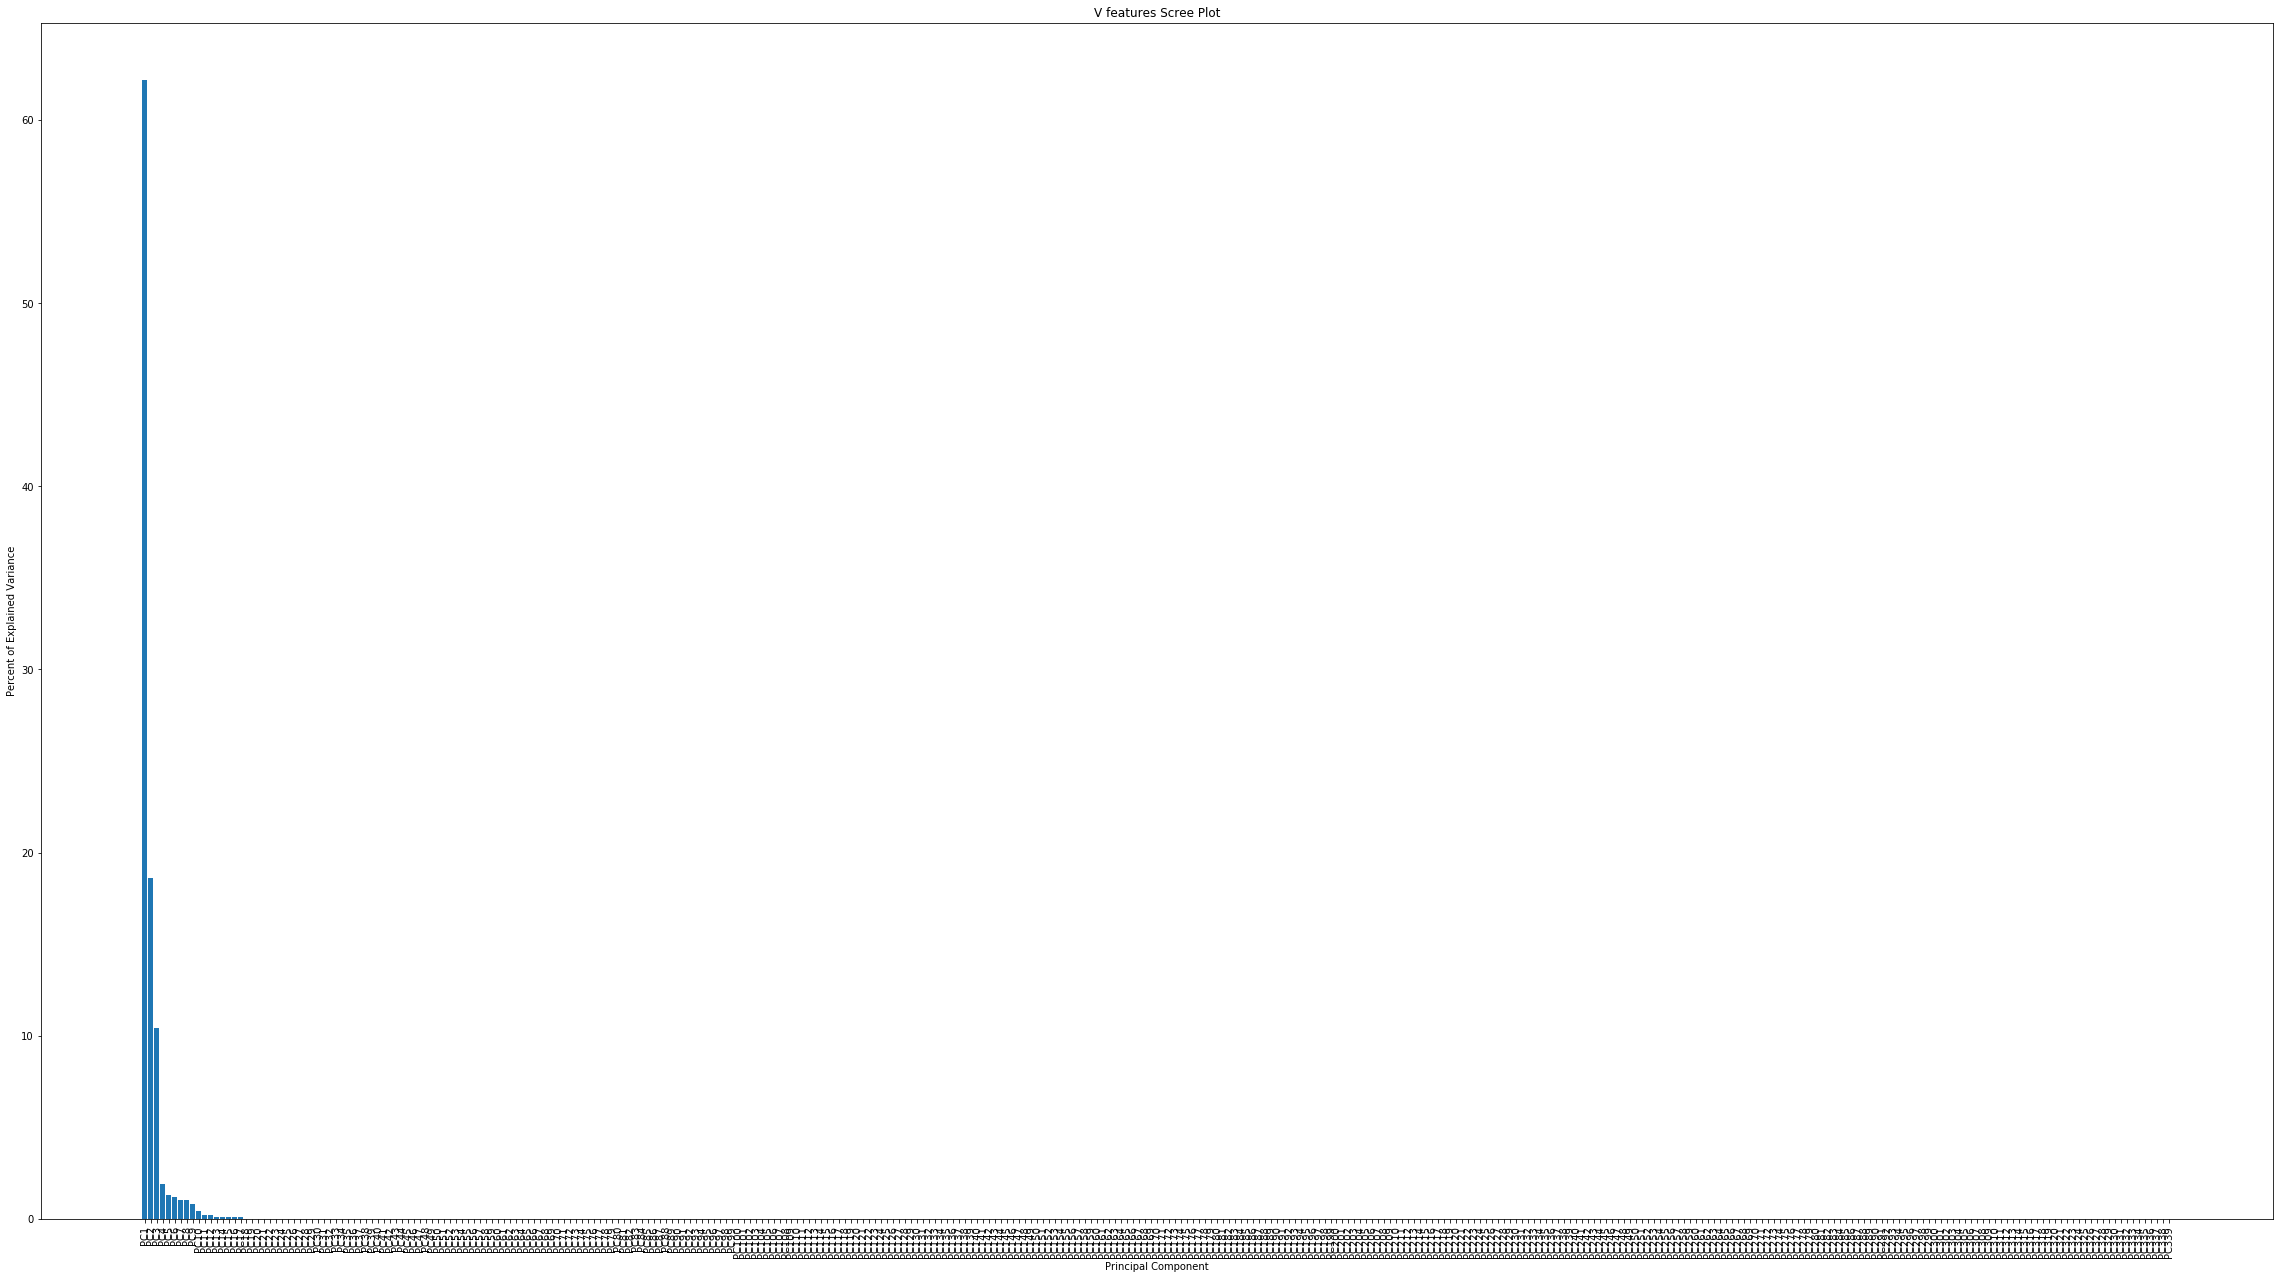

In [14]:
from matplotlib.pyplot import figure
plt.figure(figsize=(40,22))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.xticks(rotation='vertical')
plt.ylabel('Percent of Explained Variance')
plt.xlabel('Principal Component')
plt.title('V features Scree Plot')
plt.show()

## Lime 
LIME provides local model interpretability. LIME modifies a single data sample by tweaking the feature values and observes the resulting impact on the output. Often, this is also related to what humans are interested in when observing the output of a model. The most common question is probably: why was this prediction made or which variables caused the prediction?

The output of LIME is a list of explanations, reflecting the contribution of each feature to the prediction of a data sample. This provides local interpretability, and it also allows to determine which feature changes will have most impact on the prediction.

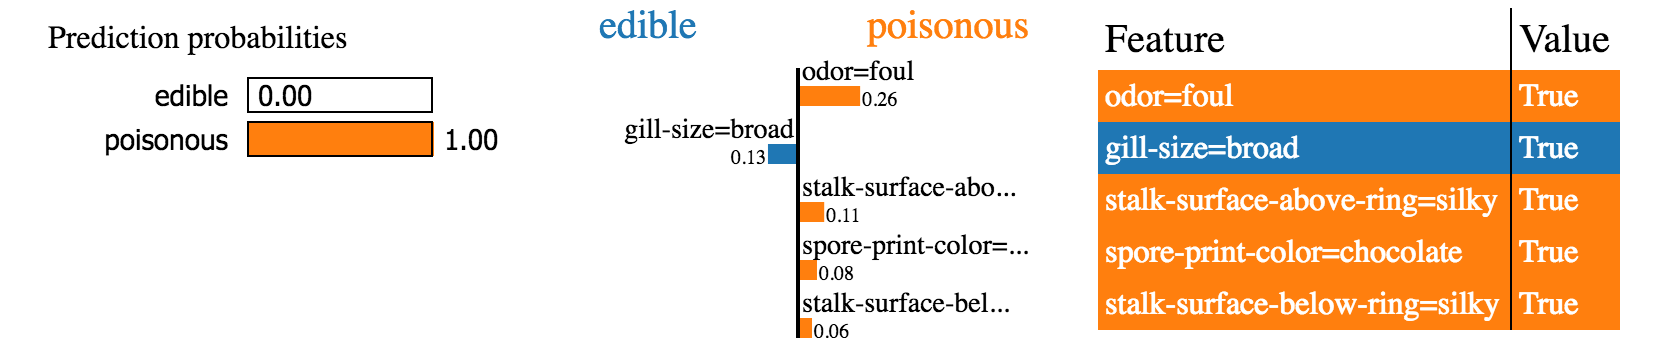

Often, simple perturbations are not enough. Ideally, the perturbations would be driven by the variation that is observed in the dataset. Manually steering the perturbations on the other is probably not a great idea, as it most likely would introduce bias into the model explanations.

LIME is a great tool to explain what machine learning classifiers (or models) are doing. 

trick to dealing with sparse data is introducing more engineering.

feature importance, intercept it with perturbations.

loop through features and perturbate it. - jumble the data randomly, then run the model to get the target label result. 
	- record the difference between the perturbated version and non-perturbated. (this all after deciding hyperperameters)
	- do it for each column, and thats your feature importance.
drop feature one, redo the model - get a success metric,
drop feature two, get the scueess metric
 - those success metrics is implicitly telling you how important that feature is.